In [2]:

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings 
import tensorflow.keras as tf
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')

In [3]:

ratings = pd.read_csv("ratings.csv")
tags = pd.read_csv("book_tags.csv")
books = pd.read_csv("books.csv")
books.head()

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",eng,4.34,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,Harry Potter and the Sorcerer's Stone (Harry P...,eng,4.44,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,"Twilight (Twilight, #1)",en-US,3.57,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,To Kill a Mockingbird,eng,4.25,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,The Great Gatsby,eng,3.89,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


In [4]:
# now we'll use sklearn to split the training and test data
X_train, X_test = train_test_split(ratings, test_size = 0.2, shuffle = True)

In [5]:

# we need to get the unique # of entries (books and users)

num_unique_books = ratings.book_id.nunique() 
num_unique_users = ratings.user_id.nunique()

In [6]:
# Now we will make the book input network
# First we want to create an input layer to accept a 1D array of book IDs 
book_inputs = tf.layers.Input(shape=[1])

# create an embedding layerr with of shape (num_unique_books +1, size_of_embedding_layer) 
size_of_embedding_layer = 15 # can be as large as we'd like, based on how large we want the embedding layer to be
embed_books = tf.layers.Embedding(num_unique_books +1, size_of_embedding_layer)(book_inputs)

# uses the functional API to pass the output of the input layer to the embedding layer
books_out = tf.layers.Flatten()(embed_books)

In [7]:
# do the same thing for the users now
user_inputs = tf.layers.Input(shape=[1])
embed_users = tf.layers.Embedding(num_unique_users +1, size_of_embedding_layer)(user_inputs)
inputs_out = tf.layers.Flatten()(embed_users)

In [8]:

# now we want to merge the layers
conc_layer = tf.layers.Concatenate()([books_out, inputs_out])
conc_layer
conc_layer.get_shape()

TensorShape([None, 30])

In [9]:

# add a dense layer with num_nodes on top of it
num_nodes = 128  # do not tweak this parameter
activ = 'relu'
x = tf.layers.Dense(num_nodes, activation = activ)(conc_layer)
x

<KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'dense')>

In [10]:
# for the recommendation layer
x_out = x = tf.layers.Dense(1, activation = activ)(x)
x_out

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_1')>

In [11]:
# now that we've defined the architecture, we can create the model. 
model = tf.Model([book_inputs, user_inputs], x_out)
model

In [12]:
lr = 0.1 
opt = tf.optimizers.Adam(learning_rate = lr)
loss = 'mean_squared_error'
model.compile(optimizer=opt, loss=loss)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 15)        150015      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 15)        801375      input_2[0][0]                    
______________________________________________________________________________________________

In [13]:
# now time to train the model and evaluate it
batch_size = 64
epochs = 5
validation = ([X_test.book_id, X_test.user_id], X_test.rating)
hist = model.fit([X_train.book_id, X_train.user_id], X_train.rating, 
                batch_size = batch_size,
                epochs = epochs, 
                verbose = 1, 
                validation_data = validation)

Epoch 1/5
12272/12272 [==============================] - 152s 12ms/step - loss: 5.7064 - val_loss: 5.3607
Epoch 2/5
12272/12272 [==============================] - 152s 12ms/step - loss: 5.5593 - val_loss: 4.8910
Epoch 3/5
12272/12272 [==============================] - 154s 13ms/step - loss: 4.8431 - val_loss: 4.7304
Epoch 4/5
12272/12272 [==============================] - 153s 12ms/step - loss: 4.7436 - val_loss: 4.8895
Epoch 5/5
12272/12272 [==============================] - 149s 12ms/step - loss: 5.0022 - val_loss: 4.7675


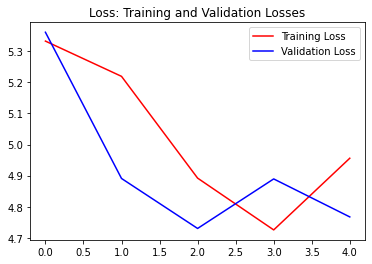

In [14]:
# now plot some summaries 
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']

plt.plot(train_loss, color='r', label='Training Loss')
plt.plot(val_loss, color='b', label='Validation Loss')
plt.title("Loss: Training and Validation Losses")
plt.legend() 
plt.show()

In [16]:
# save the model
model.save('model.h5')

# now to visualize the embeddings
book_embedding = model.get_layer('embedding')
book_embedding_weights = book_embedding.get_weights()[0]
book_embedding_weights.shape

(10001, 15)

In [17]:
# get the book titles from the books.csv
vis_books = books.copy() 
vis_books = vis_books.set_index("book_id")

In [18]:
# now need to form .tsv files
book_ids = list(ratings.book_id.unique())
dict_map = {}
for i in book_ids:
    dict_map[i] = vis_books.iloc[i-1]['title']   # copy the titles over

out_v = open('vecs.tsv', 'w')
out_m = open('meta.tsv', 'w')

for i in book_ids:
    book = dict_map[i]
    embeddings = book_embedding_weights[i]
    out_m.write(book +"\n")
    out_v.write('\t'.join([str(x) for x in embeddings]) +"\n")

out_v.close()
out_m.close()

In [19]:
# Convert into tensorflow.js model
!apt-get install python3-venv

!python -m venv .tensorflowjs-env

!source .tensorflowjs-env/bin/activate
!pip install tensorflowjs
!deactivate

!source .tensorflowjs-env/bin/activate
!tensorflowjs_converter --input_format keras model.h5 .
!deactivate

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  python-pip-whl python3.6-venv
The following NEW packages will be installed:
  python-pip-whl python3-venv python3.6-venv
0 upgraded, 3 newly installed, 0 to remove and 16 not upgraded.
Need to get 1,660 kB of archives.
After this operation, 1,902 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 python-pip-whl all 9.0.1-2.3~ubuntu1.18.04.4 [1,653 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 python3.6-venv amd64 3.6.9-1~18.04ubuntu1.3 [6,180 B]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 python3-venv amd64 3.6.7-1~18.04 [1,208 B]
Fetched 1,660 kB in 1s (1,680 kB/s)
Selecting previously unselected package python-pip-whl.
(Reading database ... 145483 files and directories currently installed.)
Preparing to unpack .../python-pip-

In [20]:
from google.colab import files
files.download('model.json')
files.download('group1-shard1of1.bin')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>